In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('data/cleaned_rounds_data_with_stats.csv')
df = df.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X = df.drop(['round_winner'], axis=1)
y = df['round_winner']

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

c:\Projects\License\Models\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        67,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,569 (303.00 KB)

 Trainable params: 77,569 (303.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5367 - loss: 3.6456 - val_accuracy: 0.7027 - val_loss: 2.5799
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6833 - loss: 2.3741 - val_accuracy: 0.7545 - val_loss: 1.8031
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7499 - loss: 1.6721 - val_accuracy: 0.7642 - val_loss: 1.3488
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7725 - loss: 1.2574 - val_accuracy: 0.7604 - val_loss: 1.0653
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7895 - loss: 0.9795 - val_accuracy: 0.7652 - val_loss: 0.8845
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7961 - loss: 0.8067 - val_accuracy: 0.7604 - val_loss: 0.7801
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.7068 - val_accuracy: 0.7647 - val_loss: 0.7071
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8006 - loss: 0.6417 - val_accu

In [25]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [26]:
print(classification_report(y_test, y_pred))

confusion_m = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion_m, index=['Actual Negative', 'Actual Positive'],
                              columns=['Predicted Negative', 'Predicted Positive'])
print(conf_matrix_df)
print({
    'true negatives': f'{round(100*confusion_m[0, 0]/len(y_test))}%',
    'false positives': f'{round(100*confusion_m[0, 1]/len(y_test))}%',
    'false negatives': f'{round(100*confusion_m[1, 0]/len(y_test))}%',
    'true positives': f'{round(100*confusion_m[1, 1]/len(y_test))}%'
})

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1133
           1       0.79      0.79      0.79      1205

    accuracy                           0.78      2338
   macro avg       0.78      0.78      0.78      2338
weighted avg       0.78      0.78      0.78      2338

                 Predicted Negative  Predicted Positive
Actual Negative                 874                 259
Actual Positive                 257                 948
{'true negatives': '37%', 'false positives': '11%', 'false negatives': '11%', 'true positives': '41%'}


ROC-AUC Score: 0.8504055989130316


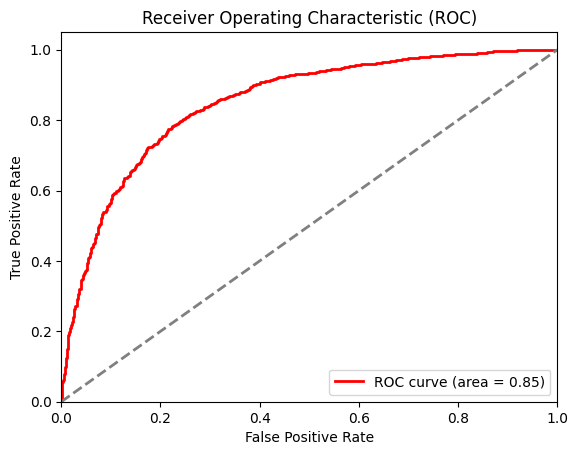

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC Score: {roc_auc}')
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()